### **RNN의 문제점**

RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어렵다. 그 원인은 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문이다.

#### **기울기 소실과 기울기 폭발의 원인**

일단, 기울기 소실은 tanh() 활성화 함수와 연관이 있다.

> y = tanh(x) <br>
dy/dx = 1 - y^2

tanh() 함수의 미분값은 대부분 1.0 미만이기 때문에, 층을 거슬러 올라가면서 tanh()의 미분값이 곱해질 수록, 기울기가 점점 작아지고, 결국 0에 가까워져 학습이 진행되지 않는 기울기 소실이 일어난다.

<br>

tahnh()함수 이외에도 matmul 노드에서 가중치가 곱해짐에 따라, 기울기 소실 혹은 기울기 폭발이 일어난다. 가중치 행렬의 특이값이 1 이상이면 기울기 폭발이, 1 미만이면 기울기 소실이 일어난다. 아래 코드로 한번 실험해보자.

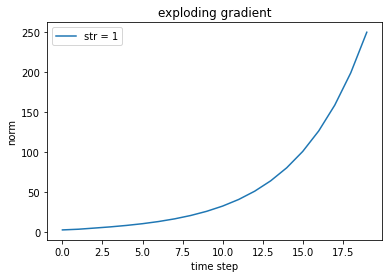

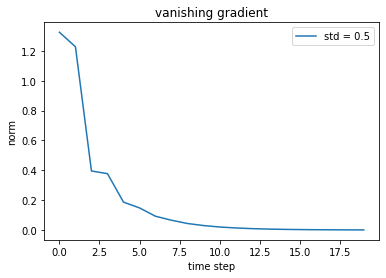

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N, H))
dh_half = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)
Wh_half = np.random.randn(H, H) * 0.5

norm_list = []
norm_half_list = []
for t in range(T):
  dh = np.matmul(dh, Wh.T)
  dh_half = np.matmul(dh_half, Wh_half.T)

  norm = np.sqrt(np.sum(dh ** 2)) / N # l2 노름을 구한다.
  norm_half = np.sqrt(np.sum(dh_half ** 2)) / N
  norm_list.append(norm)
  norm_half_list.append(norm_half)

# 표준편차가 1일 때
plt.plot(np.arange(T), norm_list,  label='str = 1')
plt.legend()
plt.xlabel('time step')
plt.ylabel('norm')
plt.title('exploding gradient')
plt.show()
print()
# 표준편차가 0.5일 때
plt.plot(np.arange(T), norm_half_list, label='std = 0.5')
plt.legend()
plt.xlabel('time step')
plt.ylabel('norm')
plt.title('vanishing gradient')
plt.show()

#### **기울기 폭발 대책**

기울기 폭발을 방지하는 전통적인 기법은 바로 기울기 클리핑(gradients clipping)이라고 한다.

> if ||g^|| > threshold:<br>
g^ = (threshold / ||g^||) * g^

여기서 g^는 신경망에 사용되는 모든 가중치의 기울기의 합이며, ||g^||는 기울기의 l2 노름이다. 이 l2 노름이 임계값을 초과하면 강제로 기울기의 값을 작게 조정하는 것이다.

In [3]:
dW1 = np.random.randn(3, 3) * 10
dW2 = np.random.randn(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad ** 2)
  total_norm = np.sqrt(total_norm)

  rate = max_norm / (total_norm + 1e-6)
  if rate < 1:
    for grad in grads:
      grad *= rate

### **LSTM**

LSTM은 RNN의 기울기 소실 문제를 해결하기 위해 은닉층 이외에도 기억 셀(C)과 여러 게이트들을 추가한 순환신경망이다.

> f = sigmoid(x<sub>t</sub>W<sub>fx</sub> + h<sub>t-1</sub>W<sub>fh</sub>+b<sub>f</sub>) <br>
g = tanh(x<sub>t</sub>W<sub>gx</sub> + h<sub>t-1</sub>W<sub>gh</sub>+b<sub>g</sub>) <br>
i = sigmoid(x<sub>t</sub>W<sub>ix</sub> + h<sub>t-1</sub>W<sub>ih</sub>+b<sub>i</sub>) <br>
o = simogid(x<sub>t</sub>W<sub>ox</sub> + h<sub>t-1</sub>W<sub>oh</sub>+b<sub>o</sub>) <br><br>
c<sub>t</sub> = f⊙c<sub>t-1</sub> + g⊙i <br>
h<sub>t</sub> = o⊙tanh(c<sub>t-1</sub>)

LSTM에서는 각 게이트의 활성화 함수로 sigmoid와 tanh함수를 섞어서 사용하는데, 이는 각 게이트의 목적과 활성화 함수의 출력값 범위과 연관이 있다.

> tanh의 출력은 -1.0 ~ 1.0의 실수이다. 이 -1.0 ~ 1.0의 수치를 그 안에 인코딩된 정보의 강약(정도)을 표시한다고 해석할 수 있다. 한편 시그모이드 함수의 출력은 0.0 ~ 1.0의 실수이며, 데이터를 얼마만큼 통과시킬지를 정하는 비율을 뜻한다. 따라서 (주로) 게이트에서는 시그모이드 함수가, 실질적인 '정보'를 지니는 데이터에는 tanh 함수가 활성화 함수로 사용된다.

In [4]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(param) for param in self.params]
    self.cache = None
  
  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

    # slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

  def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache

    tanh_c_next = np.tanh(c_next)
    ds = (dh_next * o) * (1 - tanh_c_next**2) + dc_next

    dc_prev = ds * f
    
    df = ds * c_prev
    dg = ds * i
    di = ds * g
    do = dh_next * tanh_c_next

    df *= f * (1 - f)
    dg *= (1 - g ** 2)
    di *= i * (1 - i)
    do *= o * (1 - o)

    dA = np.hstack((df, dg, di, do))

    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = np.sum(dA, axis=0)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db 

    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)

    return dx, dh_prev, dc_prev

class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(param) for param in self.params]
    self.layers = None

    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype=np.float32)
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype=np.float32)

    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
      hs[:, t, :] = self.h

      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D), dtype=np.float32)
    dh, dc = 0, 0

    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh
    return dxs

  def set_state(self, h, c=None):
    self.h, self.c = h, c

  def reset_state(self):
    self.h, self.c = None, None

학습에 필요한 다른 Time 계층도 만든다.

In [5]:
# softmax
def softmax(x):
  if x.ndim == 2:
    x -= x.max(axis=1, keepdims=True)
    x = np.exp(x)
    x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
    x = x - np.max(x)
    x = np.exp(x) / np.sum(np.exp(x))

  return x

class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None

  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out

  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    np.add.at(dW, self.idx, dout)
    return None

# TimeEmbedding
class TimeEmbedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.layers = None
    self.W = W

  def forward(self, xs):
    N, T = xs.shape
    V, D = self.W.shape

    out = np.empty((N, T, D), dtype='f')
    
    self.layers = []
    for t in range(T):
      layer = Embedding(self.W)
      out[:, t, :] = layer.forward(xs[:, t])
      self.layers.append(layer)

    return out

  def backward(self, dout):
    N, T, D = dout.shape

    grad = 0
    for t in reversed(range(T)):
      layer = self.layers[t]
      layer.backward(dout[:, t, :])
      grad += layer.grads[0]

    self.grads[0][...] = grad
    return None

# TimeAffine
class TimeAffine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = [np.zeros_like(W), np.zeros_like(b)]
    self.x = None

  def forward(self, x):
    N, T, D = x.shape
    W, b = self.params

    rs = x.reshape(N*T, -1)
    out = np.dot(rs, W) + b
    self.x = x
    return out.reshape(N, T, -1)

  def backward(self, dout):
    x = self.x
    N, T, D = x.shape
    W, b = self.params

    dout = dout.reshape(N*T, -1)
    rx = x.reshape(N*T, -1)

    db = np.sum(dout, axis=0)
    dW = np.dot(rx.T, dout)
    dx = np.dot(dout, W.T)
    dx = dx.reshape(*x.shape)

    self.grads[0][...] = dW
    self.grads[1][...] = db

    return dx

# TimeSoftmaxWithLoss
class TimeSoftmaxWithLoss:
  def __init__(self):
    self.params, self.grads= [], []
    self.cache = None
    self.ignore_label = -1

  def forward(self, xs, ts):
    N, T, V = xs.shape

    # 원-핫 벡터로 라벨링 되었을 경우
    if ts.ndim == 3:
      ts = ts.argmax(axis=2)

    mask = (ts != self.ignore_label)

    xs = xs.reshape(N*T, -1)
    ts = ts.reshape(N*T)
    mask = mask.reshape(N*T)

    ys = softmax(xs)
    ls = np.log(ys[np.arange(N*T), ts])
    ls *= mask
    loss = -np.sum(ls)
    loss /= np.sum(mask)

    self.cache = (ts, ys, mask, (N, T, V))
    return loss

  def backward(self, dout=1):
    ts, ys, mask, (N, T, V) = self.cache

    dx = ys
    dx[np.arange(N*T), ts] -= 1
    dx *= dout
    dx /= mask.sum()
    dx *= mask[:, np.newaxis]
    
    dx = dx.reshape((N, T, V))
    return dx

LSTM으로 구성된 Rnnlm 클래스를 만든다.

In [6]:
import pickle

class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size

    # Xvaier 초기화
    embed_W = (np.random.randn(V, D) / 100).astype(np.float32)
    lstm_Wx = (np.random.randn(D, 4 * H) / np.sqrt(D)).astype(np.float32)
    lstm_Wh = (np.random.randn(H, 4 * H) / np.sqrt(H)).astype(np.float32)
    lstm_b = np.zeros(4 * H).astype(np.float32)
    affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)

    self.layers = [
      TimeEmbedding(embed_W),
      TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
      TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()

  # 학습된 가중치를 저장
  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)

  # 저장된 가중치를 불러옴
  def load_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f)

Rnnlm을 학습하는데 필요한 RnnlmTrainer() 클래스를 코딩한다.

In [7]:
import time

# 중복된 가중치 제거
def remove_duplicate(params, grads):
  params, grads = params[:], grads[:]  # copy list

  while True:
    find_flg = False
    L = len(params)

    for i in range(0, L - 1):
      for j in range(i + 1, L):
        # 가중치 공유 시
        if params[i] is params[j]:
          grads[i] += grads[j]  # 경사를 더함
          find_flg = True
          params.pop(j)
          grads.pop(j)
        # 가중치를 전치행렬로 공유하는 경우(weight tying)
        elif params[i].ndim == 2 and params[j].ndim == 2 and \
          params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
          grads[i] += grads[j].T
          find_flg = True
          params.pop(j)
          grads.pop(j)

        if find_flg: break
      if find_flg: break

    if not find_flg: break

  return params, grads
  
class RnnlmTrainer():
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.time_idx = None
    self.ppl_list = None
    self.eval_interval = None
    self.current_epoch = 0

  def gen_batch(self, x, t, batch_size, time_size):
    batch_x = np.empty((batch_size, time_size), dtype='i')
    batch_t = np.empty((batch_size, time_size), dtype='i')

    data_size = len(x)
    jump = data_size // batch_size
    offsets = [i * jump for i in range(batch_size)]
    max_iters = data_size // (batch_size * time_size)

    for _ in range(max_iters):
      for time in range(time_size):
        for i, offset in enumerate(offsets):
          batch_x[i, time] = x[(offset + self.time_idx) % data_size]
          batch_t[i, time] = t[(offset + self.time_idx) % data_size]
        self.time_idx += 1

      yield batch_x, batch_t

  def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
    data_size = len(xs)
    max_iters = data_size // (batch_size * time_size)
    self.time_idx = 0
    self.ppl_list = []
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0

    start_time = time.time()
    for epoch in range(max_epoch):
      for iters, batch in enumerate(self.gen_batch(xs, ts, batch_size, time_size)):
        batch_x, batch_t = batch
        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
        if max_grad is not None:
          clip_grads(grads, max_grad) # gradients clipping
        optimizer.update(params, grads)
        total_loss += loss
        loss_count += 1

        if (eval_interval is not None) and (iters % eval_interval) == 0:
          ppl = np.exp(total_loss / loss_count)
          elapsed_time = time.time() - start_time
          print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                  % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
          self.ppl_list.append(float(ppl))
          total_loss, loss_count = 0, 0
      
      self.current_epoch += 1

  def plot(self, ylim=None):
    import matplotlib.pyplot as plt
    x = np.arange(len(self.ppl_list))
    if ylim is not None:
      plt.ylim(*ylim)
    plt.plot(x, self.ppl_list, label='train')
    plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
    plt.ylabel('퍼플렉서티')
    plt.show()

Rnnlm을 학습하는 코드를 작성한다.

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9997.59
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2877.64
| 에폭 1 |  반복 41 / 1327 | 시간 13[s] | 퍼플렉서티 1180.89
| 에폭 1 |  반복 61 / 1327 | 시간 19[s] | 퍼플렉서티 957.32
| 에폭 1 |  반복 81 / 1327 | 시간 25[s] | 퍼플렉서티 805.98
| 에폭 1 |  반복 101 / 1327 | 시간 32[s] | 퍼플렉서티 656.16
| 에폭 1 |  반복 121 / 1327 | 시간 39[s] | 퍼플렉서티 639.12
| 에폭 1 |  반복 141 / 1327 | 시간 45[s] | 퍼플렉서티 601.37
| 에폭 1 |  반복 161 / 1327 | 시간 52[s] | 퍼플렉서티 575.05
| 에폭 1 |  반복 181 / 1327 | 시간 58[s] | 퍼플렉서티 572.81
| 에폭 1 |  반복 201 / 1327 | 시간 65[s] | 퍼플렉서티 491.50
| 에폭 1 |  반복 221 / 1327 | 시간 71[s] | 퍼플렉서티 479.82
| 에폭 1 |  반복 241 / 1327 | 시간 77[s] | 퍼플렉서티 444.04
| 에폭 1 |  반복 261 / 1327 | 시간 84[s] | 퍼플렉서티 451.43
| 에폭 1 |  반복 281 / 1327 | 시간 90[s] | 퍼플렉서티 441.23
| 에폭 1 |  반복 301 / 1327 | 시간 97[s] | 퍼플렉서티 389.37
| 에폭 1 |  반복 321 / 1327 | 시간 103[s] | 퍼플렉서티 342.52
| 에폭 1 |  반복 341 / 1327 | 시간 109[s] | 퍼플렉서티 393.33
| 에폭 1 |  반복 361 / 1327 | 시간 116[s] | 퍼플렉서티 400.73
| 에폭 1 |  반복 381 / 1327 | 시간 122[s] | 퍼플렉서티 331.48
|

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

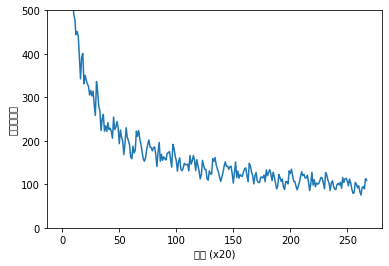

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉시티 :  135.71475937695112


In [ ]:
# optimizer
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr

  def update(self, params, grads):
    for i in range(len(params)):
      params[i] -= self.lr * grads[i]

def eval_perplexity(model, corpus, batch_size=10, time_size=35):
  print('퍼플렉서티 평가 중 ...')
  corpus_size = len(corpus)
  total_loss, loss_cnt = 0, 0
  max_iters = (corpus_size - 1) // (batch_size * time_size)
  jump = (corpus_size - 1) // batch_size

  for iters in range(max_iters):
    xs = np.zeros((batch_size, time_size), dtype=np.int32)
    ts = np.zeros((batch_size, time_size), dtype=np.int32)
    time_offset = iters * time_size
    offsets = [time_offset + (i * jump) for i in range(batch_size)]
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        xs[i, t] = corpus[(offset + t) % corpus_size]
        ts[i, t] = corpus[(offset + t + 1) % corpus_size]

    try:
      loss = model.forward(xs, ts, train_flg=False)
    except TypeError:
      loss = model.forward(xs, ts)
    total_loss += loss

    sys.stdout.write('\r%d / %d' % (iters, max_iters))
    sys.stdout.flush()

  print('')
  ppl = np.exp(total_loss / max_iters)
  return ppl

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
corpus_test, _, _ = load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉시티 : ', ppl_test)

# 매개변수 저장
model.save_params()

### **LSTM 신경망의 드롭아웃 해소**

LSTM 계층을 다층화하면 시계열 데이터의 복잡한 의존 관계를 학습할 수 있을 것이라 기대할 수 있다. 그러나 이런 모델은 종종 과적합을 일으킨다. 특히, RNN은 피드포워드 신경망보다 쉽게 과적합을 일으킨다.

<br>

이러한 과적합을 해소하기 위한 기법은 대표적으로 배치정규화와 드롭아웃이 있으며, 이번 코드에서는 드롭아웃을 사용해보겠다. RNN에서는 신경망의 깊이 방향으로 드롭아웃을 적용하는 방식과, 시간축 방향으로 적용하는 방식이 있다. 보통은 시간축 방향으로 드롭아웃을 적용하지는 않는데, 그 이유는 시간의 흐름에 back propagation을 진행할 때, 정보가 손실될 수도 있기 때문이다. 그러나 최근 연구에서는 시간축으로 Dropout을 시행하는 **Variational Dropout**을 제시하고 있다. 이 코드에서는 깊이 방향으로 Dropout을 적용한다.






In [8]:
# Dropout
class TimeDropout:
  def __init__(self, dropout_ratio=0.5):
    self.params, self.grads = [], []
    self.dropout_ratio = dropout_ratio
    self.mask = None
    self.train_flg = True

  def forward(self, xs):
    if self.train_flg:
      flg = np.random.rand(*xs.shape) > self.dropout_ratio
      scale = 1 / (1 - self.dropout_ratio)
      self.mask = flg.astype('f') * scale
      return xs * self.mask
    else:
      return xs

  def backward(self, dout):
    return dout * self.mask

위에서 구현한 TimeDropout과 가중치 공유를 사용해서 Rnnlm의 성능을 개선해보겠다.

In [9]:
import os

class BaseModel:
  def __init__(self):
    self.params, self.grads = [], []

  def forward(self, *args):
    return NotImplementedError

  def backward(self, *args):
    return NotImplementedError

  def save_params(self, file_name=None):
    if file_name is None:
      file_name = self.__class__.__name__ + '.pkl'

    params = [p.astype(np.float16) for p in self.params]

    with open(file_name, 'wb') as f:
      pickle.dump(params, f)

  def load_params(self, file_name=None):
    if file_name is None:
      file_name = self.__class__.__name__ + '.pkl'

    if '/' in file_name:
      file_name = file_name.replace('/', os.sep)

    if not os.path.exists(file_name):
      raise IOError('No file: ' + file_name)

    with open(file_name, 'rb') as f:
      params = pickle.load(f)

    params = [p.astype(np.float32) for p in params]

    for i, param in enumerate(self.params):
      param[...] = params[i]
    
class BetterRnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
    V, D, H = vocab_size, wordvec_size, hidden_size

    # Xavier 초기화
    embed_W = (np.random.randn(V, D) / 100).astype(np.float32)
    lstm_Wx1 = (np.random.randn(D, 4*H) / np.sqrt(D)).astype(np.float32)
    lstm_Wh1 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_b1 = np.zeros(4*H).astype(np.float32)
    lstm_Wx2 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_Wh2 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype(np.float32)
    lstm_b2 = np.zeros(4*H).astype(np.float32)
    affine_b = np.zeros(V).astype(np.float32)

    self.layers = [
      TimeEmbedding(embed_W), # 가중치 공유
      TimeDropout(dropout_ratio), # 드롭아웃
      TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
      TimeDropout(dropout_ratio),
      TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
      TimeDropout(dropout_ratio),
      TimeAffine(embed_W.T, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs, train_flg=False):
    for layer in self.drop_layers:
      layer.train_flg = train_flg
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts, train_flg=True):
    score = self.predict(xs, train_flg)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    for layer in self.lstm_layers:
      layer.reset_state()

BetterRnnlm을 학습하는 코드를 작성한다.

In [12]:
# 하이퍼 파라미터
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = load_data('train')
corpus_val, _, _ = load_data('val')
corpus_test, _, _ = load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
  trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)

  model.reset_state()
  ppl = eval_perplexity(model, corpus_val)
  print('검증 퍼플렉시티: ', ppl)
  
  if best_ppl > ppl:
    best_ppl = ppl
    model.save_params()
  else:
    lr /= 4.0
    optimizer.lr = lr

  model.reset_state()
  print('-' * 50)

Done
Done
| 에폭 1 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 9999.99
| 에폭 1 |  반복 21 / 1327 | 시간 68[s] | 퍼플렉서티 4025.78
| 에폭 1 |  반복 41 / 1327 | 시간 133[s] | 퍼플렉서티 1854.82
| 에폭 1 |  반복 61 / 1327 | 시간 197[s] | 퍼플렉서티 1269.67
| 에폭 1 |  반복 81 / 1327 | 시간 262[s] | 퍼플렉서티 1055.54
| 에폭 1 |  반복 101 / 1327 | 시간 327[s] | 퍼플렉서티 854.64
| 에폭 1 |  반복 121 / 1327 | 시간 391[s] | 퍼플렉서티 831.37
| 에폭 1 |  반복 141 / 1327 | 시간 456[s] | 퍼플렉서티 730.22
| 에폭 1 |  반복 161 / 1327 | 시간 521[s] | 퍼플렉서티 696.35
| 에폭 1 |  반복 181 / 1327 | 시간 587[s] | 퍼플렉서티 689.35
| 에폭 1 |  반복 201 / 1327 | 시간 652[s] | 퍼플렉서티 600.72
| 에폭 1 |  반복 221 / 1327 | 시간 718[s] | 퍼플렉서티 576.77
| 에폭 1 |  반복 241 / 1327 | 시간 783[s] | 퍼플렉서티 528.41
| 에폭 1 |  반복 261 / 1327 | 시간 852[s] | 퍼플렉서티 542.91
| 에폭 1 |  반복 281 / 1327 | 시간 918[s] | 퍼플렉서티 525.23
| 에폭 1 |  반복 301 / 1327 | 시간 984[s] | 퍼플렉서티 448.49
| 에폭 1 |  반복 321 / 1327 | 시간 1050[s] | 퍼플렉서티 402.63
| 에폭 1 |  반복 341 / 1327 | 시간 1117[s] | 퍼플렉서티 450.51
| 에폭 1 |  반복 361 / 1327 | 시간 1183[s] | 퍼플렉서티 467.19
| 에폭 1 |  반복 381 / 132